In [163]:
import pandas as pd
import numpy as np
import datetime
from time import strftime
import calendar

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [285]:
! pip install livelossplot

In [249]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    classes = np.arange(len(model.classes_))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [256]:
from sklearn.metrics import classification_report, plot_roc_curve

def print_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.plot([(0,0),(1,1)], '--y')
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

# Data cleaning

In [164]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [165]:
df = pd.read_csv('KaggleV2-May-2016.csv')

In [166]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [167]:
print("The shape of the DataFrame is => {}".format(df.shape))

The shape of the DataFrame is => (110527, 14)


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [169]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [170]:
# Convert PatientId from Float to Integer
df['PatientId'] = df['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay from 'object' type to 'datetime64[ns]'
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  int64         
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  object        
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hypertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  Handicap        110527 non-null  int64         
 12  SMSReceived     110527 non-null  int64         
 13  NoShow          110527 non-null  object        
dtypes: datetime64[ns](2), int64(9), obje

In [172]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [173]:
print(f"Features in the DataFrame => {df.columns.ravel()}")

Features in the DataFrame => ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay'
 'Age' 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes'
 'Alcoholism' 'Handicap' 'SMSReceived' 'NoShow']


In [174]:
# Drop 'PatientId' and 'AppointmentID' as they are just some system genrated numbers.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [175]:
print("Unique Values in `Gender` => {}".format(df.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(df.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(df.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(df.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(df.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(df.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(df.SMSReceived.unique()))

Unique Values in `Gender` => ['F' 'M']
Unique Values in `Scholarship` => [0 1]
Unique Values in `Hypertension` => [1 0]
Unique Values in `Diabetes` => [0 1]
Unique Values in `Alcoholism` => [0 1]
Unique Values in `Handicap` => [0 1 2 3 4]
Unique Values in `SMSReceived` => [0 1]


In [176]:
df['Scholarship'] = df['Scholarship'].astype('object')
df['Hypertension'] = df['Hypertension'].astype('object')
df['Diabetes'] = df['Diabetes'].astype('object')
df['Alcoholism'] = df['Alcoholism'].astype('object')
df['Handicap'] = df['Handicap'].astype('object')
df['SMSReceived'] = df['SMSReceived'].astype('object')

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Gender          110527 non-null  object        
 1   ScheduledDay    110527 non-null  datetime64[ns]
 2   AppointmentDay  110527 non-null  datetime64[ns]
 3   Age             110527 non-null  int64         
 4   Neighbourhood   110527 non-null  object        
 5   Scholarship     110527 non-null  object        
 6   Hypertension    110527 non-null  object        
 7   Diabetes        110527 non-null  object        
 8   Alcoholism      110527 non-null  object        
 9   Handicap        110527 non-null  object        
 10  SMSReceived     110527 non-null  object        
 11  NoShow          110527 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 10.1+ MB


In [178]:
df.sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
85687,F,2016-06-01,2016-06-01,17,CARATOÍRA,0,0,0,0,0,0,No
14277,M,2016-05-18,2016-05-20,2,GURIGICA,1,0,0,0,0,0,No
54676,M,2016-05-10,2016-05-18,54,ILHA DO PRÍNCIPE,0,0,1,0,0,0,No
65845,F,2016-05-31,2016-05-31,17,JARDIM CAMBURI,0,0,0,0,0,0,No
56450,M,2016-04-28,2016-05-18,4,ITARARÉ,0,0,0,0,0,0,No


In [179]:
print("Unique Values in `Age` => {}".format(np.sort(df.Age.unique())))

Unique Values in `Age` => [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


In [180]:
print("Patients with `Age` less than -1 -> {}".format(df[df.Age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0]))

Patients with `Age` less than -1 -> 1
Patients with `Age` equal to 0 -> 3539


As there is only 1 patient with Age less than 0 we will delete that record assuming that they was a typo.

In [181]:
df = df[df.Age >= 0]

As we have 3539 patients with Age equal to 0 we are assuming that these are the small babies with few months of Age. Usually as babies doesn't have Hypertension or Diabetes or Alcoholism we will check these features for the above records to see if our assumption is correct.

In [182]:
# We assume the age less t
df[(df.Age <= 0) & ((df.Hypertension.astype(int) == 1) | (df.Diabetes.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow


As we have no records above, we will confirm our conclusion that Age value of 0 indeed represents babies who are just few months old.

In [183]:
# Print Unique Values for 'ScheduledDay'
print("Unique Values in `ScheduledDay` => {}".format(np.sort(df.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `ScheduledDay` => ['2015-11-10' '2015-12-03' '2015-12-07' '2015-12-08' '2015-12-14'
 '2015-12-15' '2016-01-04' '2016-01-05' '2016-01-07' '2016-01-11'
 '2016-01-13' '2016-01-14' '2016-01-19' '2016-01-20' '2016-01-21'
 '2016-01-22' '2016-01-25' '2016-01-26' '2016-01-27' '2016-01-28'
 '2016-01-29' '2016-02-01' '2016-02-02' '2016-02-03' '2016-02-04'
 '2016-02-05' '2016-02-11' '2016-02-12' '2016-02-15' '2016-02-16'
 '2016-02-17' '2016-02-18' '2016-02-19' '2016-02-22' '2016-02-23'
 '2016-02-24' '2016-02-25' '2016-02-26' '2016-02-29' '2016-03-01'
 '2016-03-02' '2016-03-03' '2016-03-04' '2016-03-05' '2016-03-07'
 '2016-03-08' '2016-03-09' '2016-03-10' '2016-03-11' '2016-03-14'
 '2016-03-15' '2016-03-16' '2016-03-17' '2016-03-18' '2016-03-19'
 '2016-03-21' '2016-03-22' '2016-03-23' '2016-03-28' '2016-03-29'
 '2016-03-30' '2016-03-31' '2016-04-01' '2016-04-05' '2016-04-06'
 '2016-04-07' '2016-04-08' '2016-04-09' '2016-04-11' '2016-04-12'
 '2016-04-13' '2016-04-14' '2016-04-15' '

In [184]:
# Print Unique Values for 'AppointmentDay'
print("Unique Values in `AppointmentDay` => {}".format(np.sort(df.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `AppointmentDay` => ['2016-04-29' '2016-05-02' '2016-05-03' '2016-05-04' '2016-05-05'
 '2016-05-06' '2016-05-09' '2016-05-10' '2016-05-11' '2016-05-12'
 '2016-05-13' '2016-05-14' '2016-05-16' '2016-05-17' '2016-05-18'
 '2016-05-19' '2016-05-20' '2016-05-24' '2016-05-25' '2016-05-30'
 '2016-05-31' '2016-06-01' '2016-06-02' '2016-06-03' '2016-06-06'
 '2016-06-07' '2016-06-08']


In [185]:
# Print Unique Values for 'Neighbourhood'
print("Unique Values in `Neighbourhood` => {}".format(np.sort(df.Neighbourhood.unique())))

Unique Values in `Neighbourhood` => ['AEROPORTO' 'ANDORINHAS' 'ANTÔNIO HONÓRIO' 'ARIOVALDO FAVALESSA'
 'BARRO VERMELHO' 'BELA VISTA' 'BENTO FERREIRA' 'BOA VISTA' 'BONFIM'
 'CARATOÍRA' 'CENTRO' 'COMDUSA' 'CONQUISTA' 'CONSOLAÇÃO' 'CRUZAMENTO'
 'DA PENHA' 'DE LOURDES' 'DO CABRAL' 'DO MOSCOSO' 'DO QUADRO'
 'ENSEADA DO SUÁ' 'ESTRELINHA' 'FONTE GRANDE' 'FORTE SÃO JOÃO' 'FRADINHOS'
 'GOIABEIRAS' 'GRANDE VITÓRIA' 'GURIGICA' 'HORTO' 'ILHA DAS CAIEIRAS'
 'ILHA DE SANTA MARIA' 'ILHA DO BOI' 'ILHA DO FRADE' 'ILHA DO PRÍNCIPE'
 'ILHAS OCEÂNICAS DE TRINDADE' 'INHANGUETÁ' 'ITARARÉ' 'JABOUR'
 'JARDIM CAMBURI' 'JARDIM DA PENHA' 'JESUS DE NAZARETH' 'JOANA D´ARC'
 'JUCUTUQUARA' 'MARIA ORTIZ' 'MARUÍPE' 'MATA DA PRAIA' 'MONTE BELO'
 'MORADA DE CAMBURI' 'MÁRIO CYPRESTE' 'NAZARETH' 'NOVA PALESTINA'
 'PARQUE INDUSTRIAL' 'PARQUE MOSCOSO' 'PIEDADE' 'PONTAL DE CAMBURI'
 'PRAIA DO CANTO' 'PRAIA DO SUÁ' 'REDENÇÃO' 'REPÚBLICA' 'RESISTÊNCIA'
 'ROMÃO' 'SANTA CECÍLIA' 'SANTA CLARA' 'SANTA HELENA' 'SANTA LUÍZA'
 'SANTA

In [186]:
print("Total Count for `Neighbourhood` => {}".format(df.Neighbourhood.unique().size))

Total Count for `Neighbourhood` => 81


In [187]:
df['ScheduledDay_DOW'] = df['ScheduledDay'].dt.weekday.apply(lambda day: calendar.day_name[day])
df['AppointmentDay_DOW'] = df['AppointmentDay'].dt.weekday.apply(lambda day: calendar.day_name[day])

In [188]:
df['AppointmentDay'] = np.where((df['AppointmentDay'] - df['ScheduledDay']).\
                                dt.days < 0, df['ScheduledDay'], df['AppointmentDay'])

In [189]:
df['Waiting_Time_days'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time_days'] = df['Waiting_Time_days'].dt.days

In [190]:
print("There are [{}] records where the Waiting Time is less than Zero.".\
      format(df[df.Waiting_Time_days < 0].shape[0]))

There are [0] records where the Waiting Time is less than Zero.


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Gender              110526 non-null  object        
 1   ScheduledDay        110526 non-null  datetime64[ns]
 2   AppointmentDay      110526 non-null  datetime64[ns]
 3   Age                 110526 non-null  int64         
 4   Neighbourhood       110526 non-null  object        
 5   Scholarship         110526 non-null  object        
 6   Hypertension        110526 non-null  object        
 7   Diabetes            110526 non-null  object        
 8   Alcoholism          110526 non-null  object        
 9   Handicap            110526 non-null  object        
 10  SMSReceived         110526 non-null  object        
 11  NoShow              110526 non-null  object        
 12  ScheduledDay_DOW    110526 non-null  object        
 13  AppointmentDay_DOW  110526 no

In [192]:
df.sample(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
4092,M,2016-04-20,2016-05-04,4,MARIA ORTIZ,0,0,0,0,0,1,Yes,Wednesday,Wednesday,14
52207,M,2016-05-20,2016-05-25,77,CENTRO,0,1,1,0,2,1,No,Friday,Wednesday,5
28101,F,2016-04-14,2016-05-02,59,JARDIM DA PENHA,0,0,0,0,0,1,Yes,Thursday,Monday,18
50280,F,2016-05-02,2016-05-18,66,JARDIM DA PENHA,0,1,1,0,0,0,No,Monday,Wednesday,16
46949,F,2016-05-20,2016-05-30,72,FORTE SÃO JOÃO,0,1,0,0,0,1,No,Friday,Monday,10
79091,M,2016-04-20,2016-05-10,75,TABUAZEIRO,0,0,0,0,0,0,No,Wednesday,Tuesday,20
28623,F,2016-05-18,2016-05-25,11,ROMÃO,0,0,0,0,0,1,No,Wednesday,Wednesday,7
70365,M,2016-04-28,2016-05-12,80,CONSOLAÇÃO,0,1,0,0,0,0,No,Thursday,Thursday,14
96254,F,2016-06-01,2016-06-07,43,JARDIM DA PENHA,0,0,0,0,0,1,No,Wednesday,Tuesday,6
96651,M,2016-06-06,2016-06-08,52,CENTRO,0,0,0,0,0,0,No,Monday,Wednesday,2


# Feature distributions

In [193]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['NoShow']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['NoShow']).size()[0]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['NoShow']).size()[1]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

NoShow and Show Count of Patients

NoShow
No     88207
Yes    22319
dtype: int64

NoShow and Show '%' of Patients

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


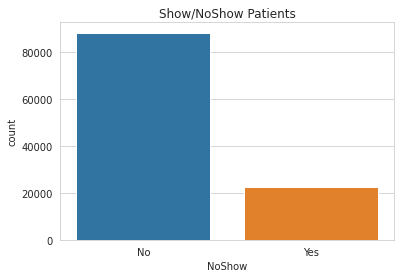

In [194]:
sns.countplot(x=df.NoShow, data=df)
plt.title("Show/NoShow Patients")
plt.show()

## gender

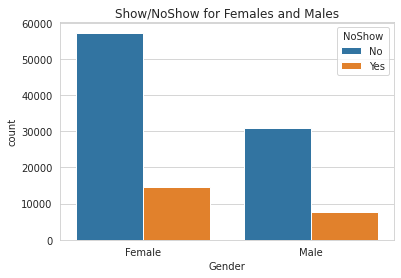

In [195]:
ax = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
plt.xticks((0,1), x_ticks_labels)
plt.show()

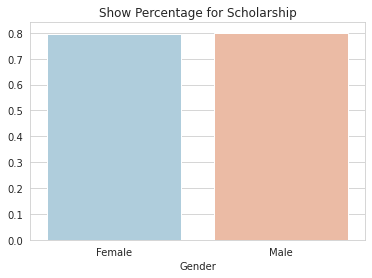

In [196]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['Gender']).size()/df.groupby(['Gender']).size()
sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
plt.title("Show Percentage for Scholarship")
x_ticks_labels=['Female', 'Male']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Age

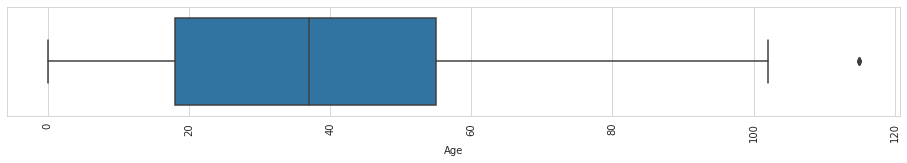

In [197]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
sns.boxplot(x=df.Age);

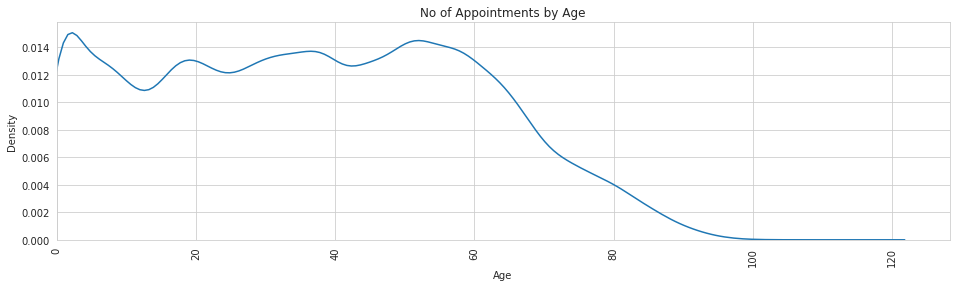

In [199]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sns.kdeplot(x=df.Age)
plt.title("No of Appointments by Age")
plt.xlim(0)
plt.show()

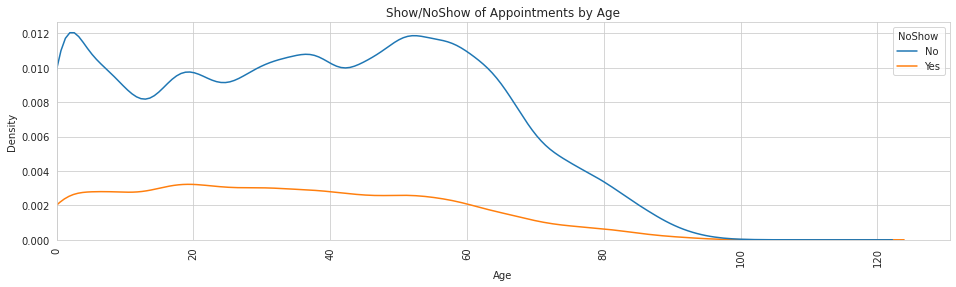

In [200]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sns.kdeplot(x=df.Age, hue=df.NoShow)
plt.title("Show/NoShow of Appointments by Age")
plt.xlim(0)
plt.show()

In [201]:
df_age_ratio = df[df.NoShow == 'No'].groupby(['Age']).size()/df.groupby(['Age']).size()

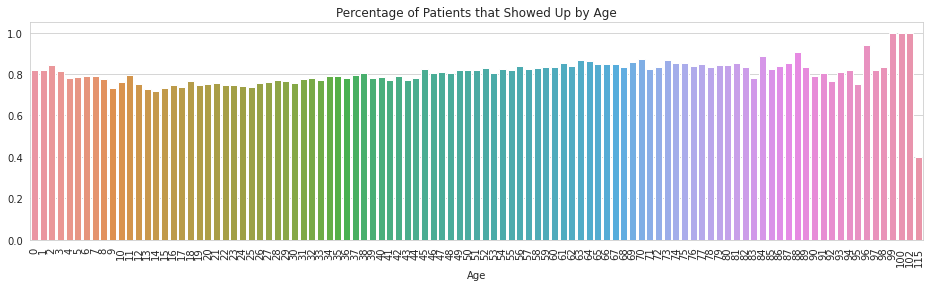

In [202]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sns.barplot(x=df_age_ratio.index, y=df_age_ratio)
plt.title("Percentage of Patients that Showed Up by Age")
plt.show()

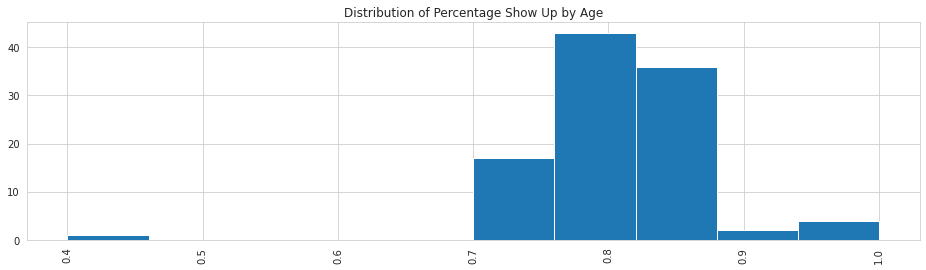

In [204]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.hist(df_age_ratio)
plt.title("Distribution of Percentage Show Up by Age")
plt.show()

## Neighbourhood

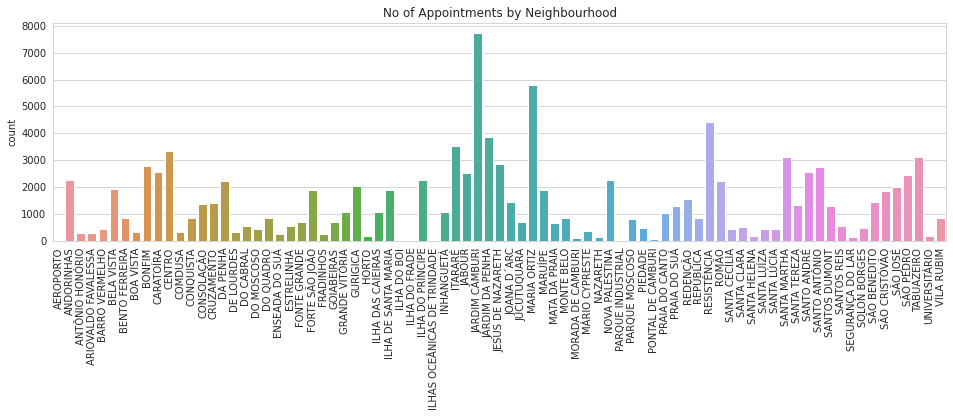

In [205]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sns.countplot(x=np.sort(df.Neighbourhood))
plt.title("No of Appointments by Neighbourhood")
plt.show()

In [206]:
df_n_ratio = df[df.NoShow == 'No'].groupby(['Neighbourhood']).size()/df.groupby(['Neighbourhood']).size()

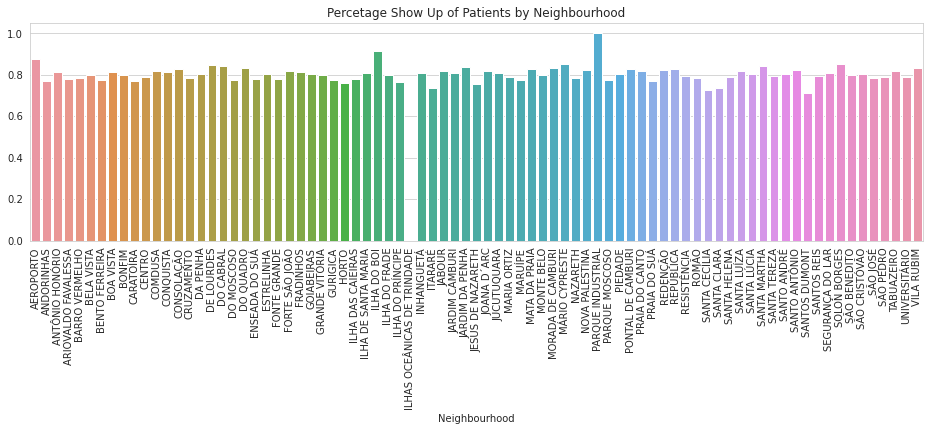

In [207]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
sns.barplot(x=df_n_ratio.index, y=df_n_ratio)
plt.title("Percetage Show Up of Patients by Neighbourhood")
plt.show()

## Scholarship

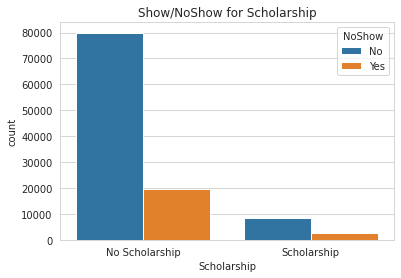

In [208]:
sns.countplot(x=df.Scholarship, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
plt.xticks((0,1), x_ticks_labels)
plt.show()

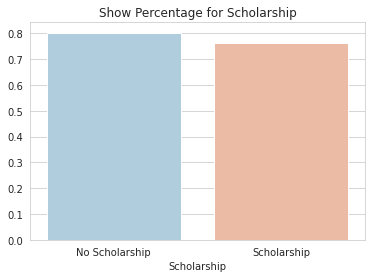

In [209]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['Scholarship']).size()/df.groupby(['Scholarship']).size()
sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
plt.title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Hypertension

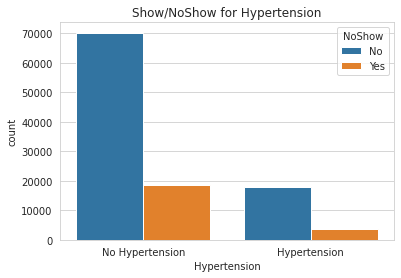

In [210]:
sns.countplot(x=df.Hypertension, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
plt.xticks((0,1), x_ticks_labels)
plt.show()

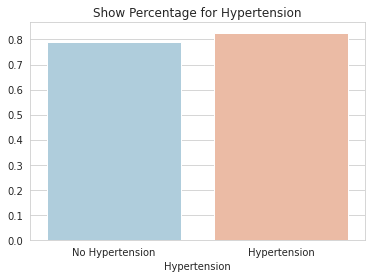

In [211]:
df_h_ratio = df[df.NoShow == 'No'].groupby(['Hypertension']).size()/df.groupby(['Hypertension']).size()
sns.barplot(x=df_h_ratio.index, y=df_h_ratio, palette="RdBu_r")
plt.title("Show Percentage for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Diabetes

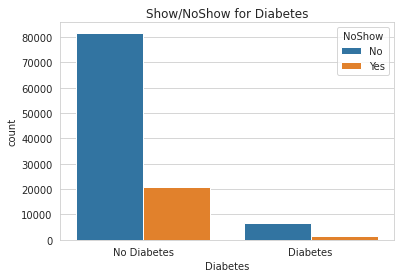

In [212]:
sns.countplot(x=df.Diabetes, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
plt.xticks((0,1), x_ticks_labels)
plt.show()

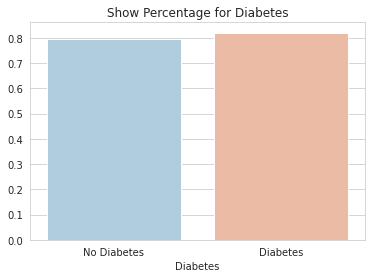

In [213]:
df_d_ratio = df[df.NoShow == 'No'].groupby(['Diabetes']).size()/df.groupby(['Diabetes']).size()
sns.barplot(x=df_d_ratio.index, y=df_d_ratio, palette="RdBu_r")
plt.title("Show Percentage for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Alcoholism

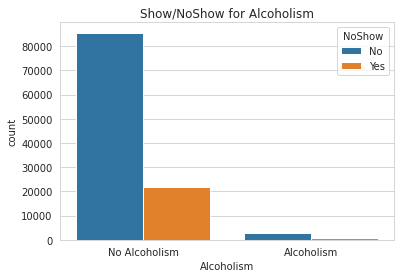

In [214]:
sns.countplot(x=df.Alcoholism, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
plt.xticks((0,1), x_ticks_labels)
plt.show()

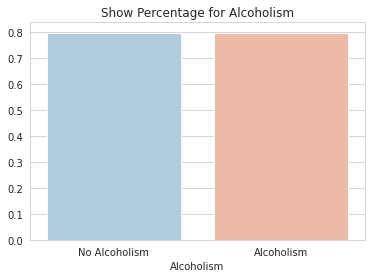

In [215]:
df_a_ratio = df[df.NoShow == 'No'].groupby(['Alcoholism']).size()/df.groupby(['Alcoholism']).size()
sns.barplot(x=df_a_ratio.index, y=df_a_ratio, palette="RdBu_r")
plt.title("Show Percentage for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Handicap

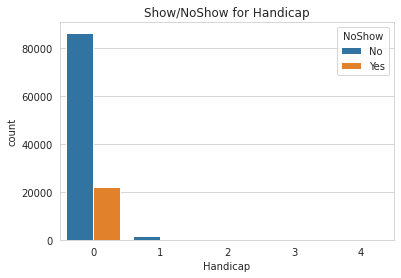

In [216]:
sns.countplot(x=df.Handicap, hue=df.NoShow, data=df)
plt.title("Show/NoShow for Handicap")
plt.show()

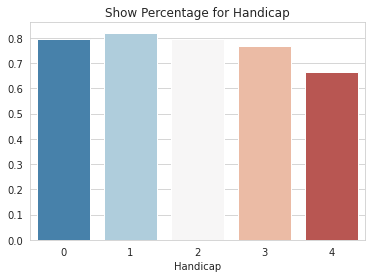

In [217]:
df_ha_ratio = df[df.NoShow == 'No'].groupby(['Handicap']).size()/df.groupby(['Handicap']).size()
ax = sns.barplot(x=df_ha_ratio.index, y=df_ha_ratio, palette="RdBu_r")
plt.title("Show Percentage for Handicap")
plt.show()

## SMSReceived

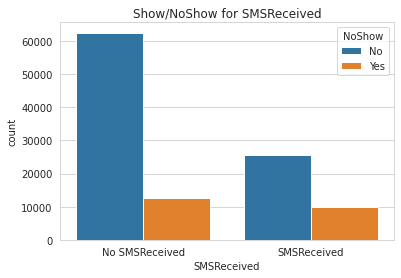

In [218]:
sns.countplot(x=df.SMSReceived, hue=df.NoShow, data=df)
plt.title("Show/NoShow for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
plt.xticks((0,1), x_ticks_labels)
plt.show()

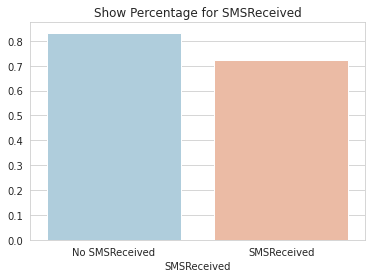

In [219]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['SMSReceived']).size()/df.groupby(['SMSReceived']).size()
sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
plt.title("Show Percentage for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
plt.xticks((0,1), x_ticks_labels)
plt.show()

## Day of Week

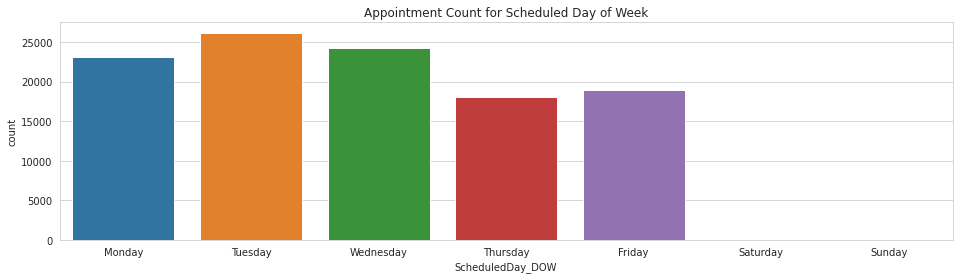

In [220]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.ScheduledDay_DOW, order=week_key)
plt.title("Appointment Count for Scheduled Day of Week")
plt.show()

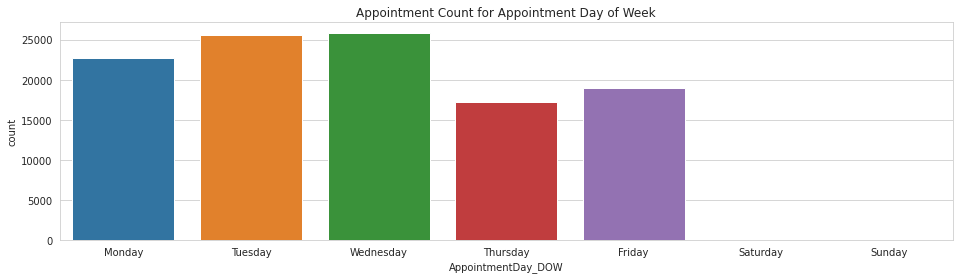

In [221]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.AppointmentDay_DOW, order=week_key)
plt.title("Appointment Count for Appointment Day of Week")
plt.show()

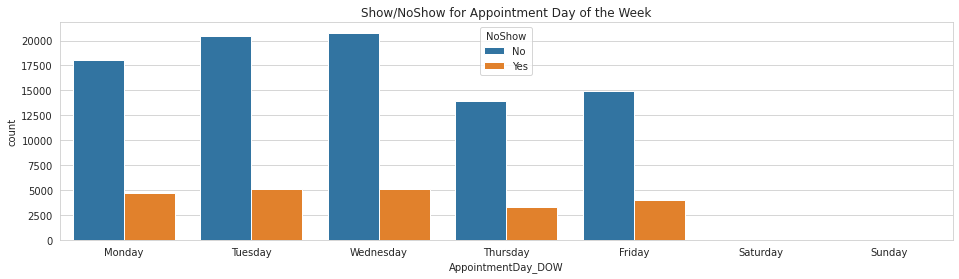

In [222]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.AppointmentDay_DOW, hue=df.NoShow, order=week_key)
plt.title("Show/NoShow for Appointment Day of the Week")
plt.show()

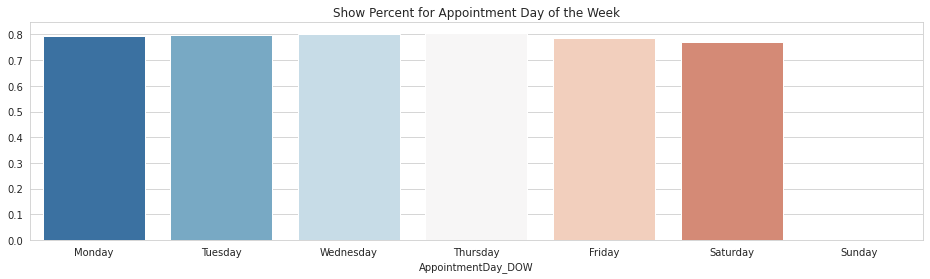

In [223]:
df_a_dow_ratio = df[df.NoShow == 'No'].groupby(['AppointmentDay_DOW']).size()/df.groupby(['AppointmentDay_DOW']).size()
plt.figure(figsize=(16,4))
sns.barplot(x=df_a_dow_ratio.index, y=df_a_dow_ratio, order=week_key, palette="RdBu_r")
plt.title("Show Percent for Appointment Day of the Week")
plt.show()

## waiting time

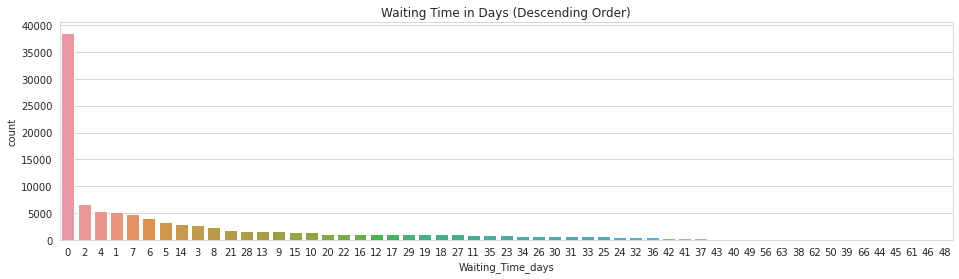

In [224]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts().iloc[:55].index)
plt.title("Waiting Time in Days (Descending Order)")
plt.show()

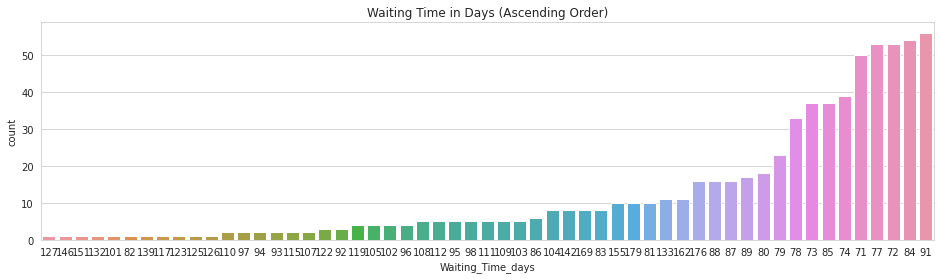

In [225]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
plt.title("Waiting Time in Days (Ascending Order)")
plt.show()

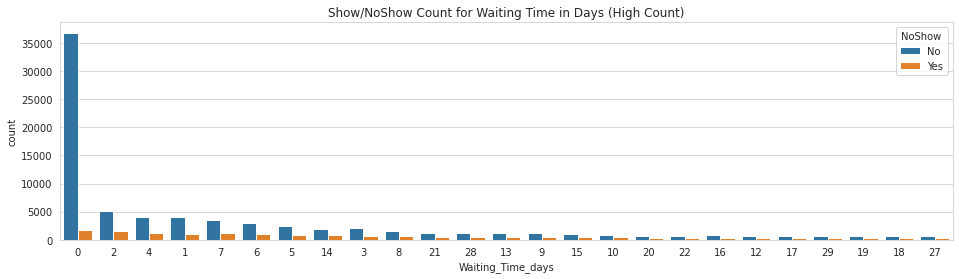

In [226]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts().iloc[:25].index)
plt.title("Show/NoShow Count for Waiting Time in Days (High Count)")
plt.show()

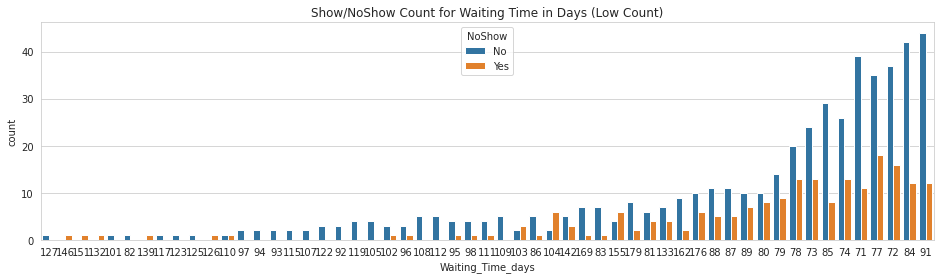

In [227]:
plt.figure(figsize=(16,4))
sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
plt.title("Show/NoShow Count for Waiting Time in Days (Low Count)")
plt.show()

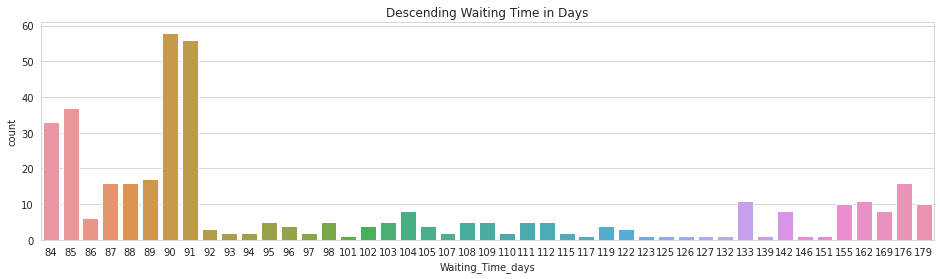

In [228]:
plt.figure(figsize=(16,4))
sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400])
plt.title("Descending Waiting Time in Days")
plt.show()

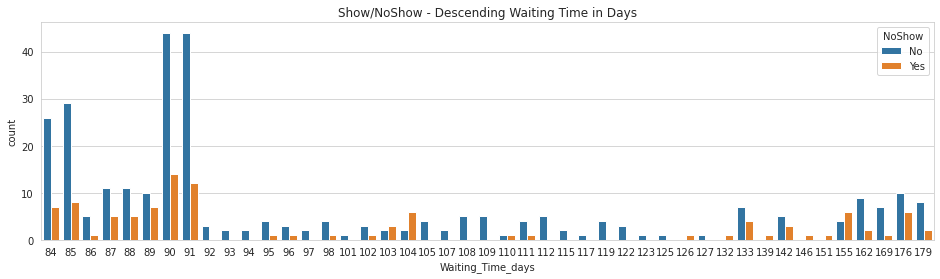

In [229]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400], hue=df.NoShow)
ax.set_title("Show/NoShow - Descending Waiting Time in Days")
plt.show()

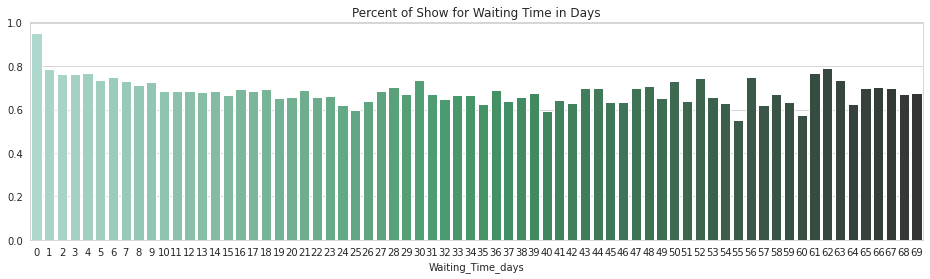

In [230]:
df_w_ratio = df[df.NoShow == 'No'].groupby(['Waiting_Time_days']).size()/df.groupby(['Waiting_Time_days']).size()

plt.figure(figsize=(16,4))
ax = sns.barplot(x=df_w_ratio.index, y=df_w_ratio, order=df.Waiting_Time_days.iloc[:70].index, palette="BuGn_d")
ax.set_title("Percent of Show for Waiting Time in Days")
plt.show()

# Model Building

## Encoding

In [231]:
# Use `LabelEncoder` to encode labels with value between 0 and n_classes-1.
#Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
#Neighbourhood
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
#ScheduledDay_DOW
le = LabelEncoder()
df['ScheduledDay_DOW'] = le.fit_transform(df['ScheduledDay_DOW'])
#AppointmentDay_DOW
le = LabelEncoder()
df['AppointmentDay_DOW'] = le.fit_transform(df['AppointmentDay_DOW'])
print("LabelEncoder Completed")

#NoShow
le = LabelEncoder()
df['NoShow'] = le.fit_transform(df['NoShow'])

LabelEncoder Completed


In [233]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

In [234]:
df.sample(n=10)

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
40993,0,46,43,0,0,0,0,0,0,0,5,5,0,2016,5,25,2016,5,25
33022,1,7,43,0,0,0,0,0,0,1,4,5,1,2016,5,10,2016,5,11
62738,1,59,38,0,1,1,0,0,0,0,1,0,4,2016,5,16,2016,5,20
62304,1,47,25,0,0,0,0,0,0,0,1,3,31,2016,4,18,2016,5,19
83849,1,19,75,0,0,0,0,0,0,0,1,1,0,2016,5,9,2016,5,9
59291,0,75,26,0,1,1,0,0,0,0,1,5,2,2016,5,16,2016,5,18
104913,1,43,1,0,1,1,0,0,0,0,4,3,2,2016,5,31,2016,6,2
40524,1,46,37,0,0,0,0,0,0,0,4,4,0,2016,5,31,2016,5,31
78505,0,31,8,1,0,0,0,0,0,0,4,0,3,2016,5,10,2016,5,13
16074,0,21,68,0,0,0,0,0,0,0,4,5,1,2016,5,3,2016,5,4


## Baseline model

In [309]:
X = df.drop(['NoShow'], axis=1)
y = df['NoShow']

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [253]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [244]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print(f"{name} -- {round(importance, 2)}")

Feature Importance:

Gender -- 0.29
Age -- 0.25
Neighbourhood -- 0.14
Scholarship -- 0.06
Hypertension -- 0.06
Diabetes -- 0.04
Alcoholism -- 0.04
Handicap -- 0.03
SMSReceived -- 0.02
ScheduledDay_DOW -- 0.02
AppointmentDay_DOW -- 0.01
Waiting_Time_days -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.0
AppointmentDay_D -- 0.0


In [240]:
rf_clf.score(X_test, y_test)

0.7828041892855184

In [250]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rf_clf = RandomForestClassifier(random_state=42)
clf_grid = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.4s finished


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.7968184522234261


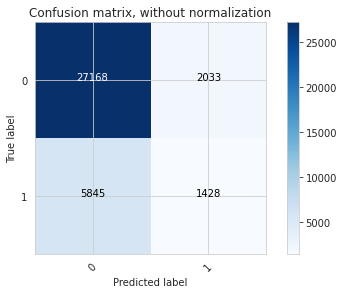

In [254]:
plot_confusion_matrix(rf_clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     29201
           1       0.41      0.20      0.27      7273

    accuracy                           0.78     36474
   macro avg       0.62      0.56      0.57     36474
weighted avg       0.74      0.78      0.75     36474



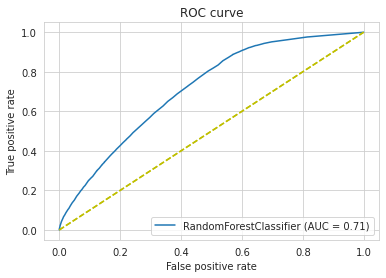

In [258]:
print_roc(rf_clf, X_test, y_test)

## DNN

18 Input features -- 
1 prediction

In [259]:
X.shape

(110526, 18)

In [262]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [310]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Gender              110526 non-null  int64 
 1   Age                 110526 non-null  int64 
 2   Neighbourhood       110526 non-null  int64 
 3   Scholarship         110526 non-null  object
 4   Hypertension        110526 non-null  object
 5   Diabetes            110526 non-null  object
 6   Alcoholism          110526 non-null  object
 7   Handicap            110526 non-null  object
 8   SMSReceived         110526 non-null  object
 9   ScheduledDay_DOW    110526 non-null  int64 
 10  AppointmentDay_DOW  110526 non-null  int64 
 11  Waiting_Time_days   110526 non-null  int64 
 12  ScheduledDay_Y      110526 non-null  int64 
 13  ScheduledDay_M      110526 non-null  int64 
 14  ScheduledDay_D      110526 non-null  int64 
 15  AppointmentDay_Y    110526 non-null  int64 
 16  Ap

### Feature pre-prossesing

In [316]:
X = df.drop(['NoShow'], axis=1)
y = df['NoShow']

In [322]:
from sklearn.preprocessing import MinMaxScaler

In [317]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Gender              110526 non-null  int64 
 1   Age                 110526 non-null  int64 
 2   Neighbourhood       110526 non-null  int64 
 3   Scholarship         110526 non-null  object
 4   Hypertension        110526 non-null  object
 5   Diabetes            110526 non-null  object
 6   Alcoholism          110526 non-null  object
 7   Handicap            110526 non-null  object
 8   SMSReceived         110526 non-null  object
 9   ScheduledDay_DOW    110526 non-null  int64 
 10  AppointmentDay_DOW  110526 non-null  int64 
 11  Waiting_Time_days   110526 non-null  int64 
 12  ScheduledDay_Y      110526 non-null  int64 
 13  ScheduledDay_M      110526 non-null  int64 
 14  ScheduledDay_D      110526 non-null  int64 
 15  AppointmentDay_Y    110526 non-null  int64 
 16  Ap

In [321]:
for feature in X.columns:
    X[feature] = X[feature].astype('int')

NameError: ignored

In [325]:
scaler = MinMaxScaler()
scaler.fit(X)
X_t = scaler.transform(X)

In [347]:
layers = []
layers.append(Dense(40, input_dim=18, activation='sigmoid', name='fc_1')) # 1st fully connected layer
layers.append(Dense(1, activation='sigmoid', name='fc_2')) # 1st fully connected layer
model = Sequential(layers, name='show/no_show')

In [348]:
model.compile(
    optimizer='rmsprop', 
    loss='mse', 
    metrics=['accuracy'])

In [281]:
model.summary()

Model: "show/no_show"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_1 (Dense)                 (None, 40)                760       
_________________________________________________________________
fc_2 (Dense)                 (None, 1)                 41        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


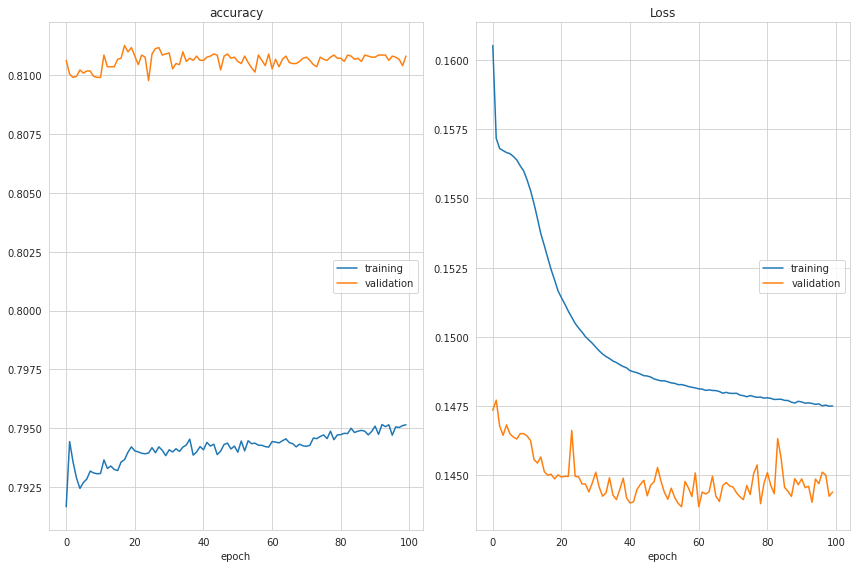

accuracy
	training         	 (min:    0.792, max:    0.795, cur:    0.795)
	validation       	 (min:    0.810, max:    0.811, cur:    0.811)
Loss
	training         	 (min:    0.147, max:    0.161, cur:    0.148)
	validation       	 (min:    0.144, max:    0.148, cur:    0.144)


In [349]:
from livelossplot import PlotLossesKeras

history = model.fit(x=X_t, y=y, validation_split=0.2,
                    epochs=100, batch_size=50, verbose=-1,
                    callbacks=[PlotLossesKeras()])

In [354]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [359]:
history_sum = {'loss': [], 'accuracy': [], 'val_loss': []}

In [360]:
history_sum

{'loss': []}

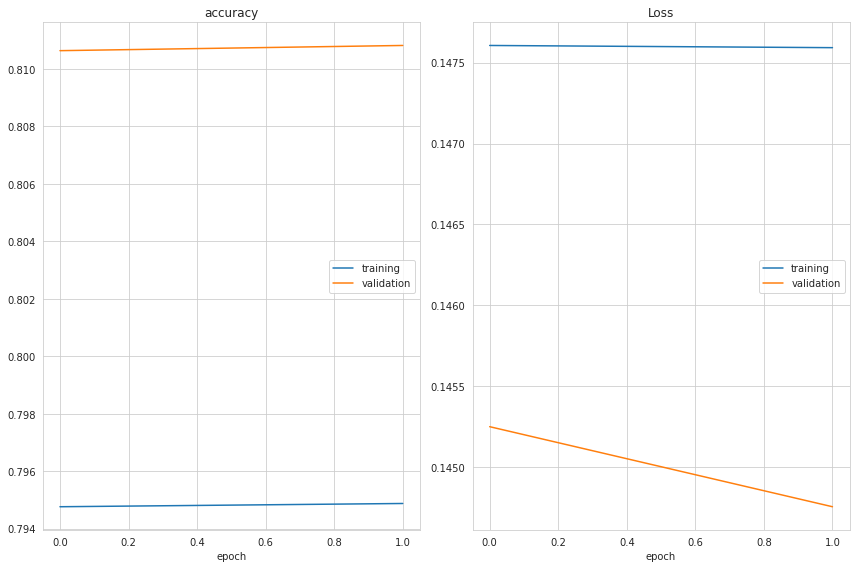

accuracy
	training         	 (min:    0.795, max:    0.795, cur:    0.795)
	validation       	 (min:    0.811, max:    0.811, cur:    0.811)
Loss
	training         	 (min:    0.148, max:    0.148, cur:    0.148)
	validation       	 (min:    0.145, max:    0.145, cur:    0.145)
Epoch 3/50
821/885 [==========================>...] - ETA: 0s - loss: 0.1476 - accuracy: 0.7948

KeyboardInterrupt: ignored

In [346]:
history = model.fit(x=X_t, y=y, validation_split=0.2,
                    epochs=50, batch_size=100, verbose=1,
                    callbacks=[PlotLossesKeras()])

In [331]:
y[5]

0

In [344]:
model.predict(X.iloc[10].to_numpy().reshape(1,-1))

array([[0.85]], dtype=float32)